# Example of using PyImfit to Estimate B/T Uncertainties

This is a Jupyter notebook demonstrating how to use PyImfit and bootstrap resampling to estimate uncertainties for derived quantities of fits, such as $B/T$ values.

If you are seeing this as part of the readthedocs.org HTML documentation, you can retrieve the original .ipynb file
[here](https://github.com/perwin/pyimfit/blob/master/docs/pyimfit_bootstrap_BtoT.ipynb).


The basic idea is this: PyImfit will estimate uncertainties for individual parameters from a fit (if you use the default Levenberg-Marquardt minimizer). You can also estimate parameter uncertainties via bootstrap resampling, or by using an external Markov-Chain Monte Carlo algorithm (see [here](./pyimfit_emcee.html) for an example of this).

But you might also want to have some estimate of derived values based on a model, such as the total luminosity or the bulge/total ($B/T$) value (assuming you have some idea of which component in your model is the "bulge"). This notebook shows a simple example of how one might do that, using PyImfit's bootstrap-resampling option.


**Preliminaries**

Some initial setup for nice-looking plots:

In [1]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Create image-fitting model using PyImfit

Load the pymfit package; also load numpy and astropy.io.fits (so we can read FITS files):

In [2]:
import numpy as np
import pyimfit
from astropy.io import fits

Load data image (SDSS $r$-band image cutout of VCC 1512) and corresponding mask:

In [23]:
imageFile = "./pyimfit_bootstrap_BtoT_files/vcc1512rss_cutout.fits"
image_vcc1512 = fits.getdata(imageFile)
maskFile = "./pyimfit_bootstrap_BtoT_files/vcc1512rss_mask_cutout.fits"
mask_vcc1512 = fits.getdata(maskFile)

Create a ModelDescription instance based on an imfit configuration file (which specifies a Sersic + Exponential model):

In [24]:
configFile = "./pyimfit_bootstrap_BtoT_files/config_imfit_vcc1512.dat"
model_desc = pyimfit.ModelDescription.load(configFile)

In [5]:
print(model_desc)

ORIGINAL_SKY	120.020408
GAIN	4.725000
READNOISE	4.300000
X0		60.0
Y0		73.0
FUNCTION Sersic
PA		155.0		90.0,180.0
ell		0.2		0.0,0.5
n		2.05		0.0,4.0
I_e		120.0		0.0,10000.0
r_e		4.5		0.0,20.0

FUNCTION Exponential
PA		140.0		90.0,180.0
ell		0.28		0.0,0.8
I_0		70.0		0.0,10000.0
h		20.0		0.0,200.0



Create an Imfit instance containing the model, and add the image and mask data. Note that we are *not* doing PSF convolution, in order to save time; this is not meant to be a particular accurate model.

In [6]:
imfit_fitter = pyimfit.Imfit(model_desc)
imfit_fitter.loadData(image_vcc1512, mask=mask_vcc1512)

Fit the model to the data (using the default Levenberg-Marquardt solver) and extract the best-fitting parameter values:

In [7]:
results = imfit_fitter.doFit(getSummary=True)

In [8]:
print(results)

            aic: 21156.824446201397
            bic: 21242.642276390998
   fitConverged: True
        fitStat: 21134.809840392267
 fitStatReduced: 1.169219398118625
          nIter: 10
      paramErrs: array([0.01518161, 0.0167467 , 1.88166351, 0.00733777, 0.01613089,
       1.9553319 , 0.05896027, 0.65080573, 0.00529781, 1.11196358,
       0.18740197])
         params: array([6.04336387e+01, 7.32059007e+01, 1.61799952e+02, 1.18947666e-01,
       9.56352657e-01, 1.21814611e+02, 4.86558532e+00, 1.38986928e+02,
       2.73912311e-01, 8.13853830e+01, 2.08521933e+01])
     solverName: 'LM'


In [9]:
results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params

print("Best-fitting parameter values:")
for i in range(len(p_bestfit) - 1):
    print("{0:g}".format(p_bestfit[i]), end=", ")
print("{0:g}\n".format(p_bestfit[-1]))

Best-fitting parameter values:
60.4336, 73.2059, 161.801, 0.118946, 0.956308, 121.821, 4.86538, 138.987, 0.273911, 81.389, 20.8517



### Run bootstrap-resampling to generate a set of parameter values (array of best-fit parameter vectors)

OK, now we're going to do some bootstrap resampling to build up a set of several hundred alternate "best-fit" parameter values.

Note that you coul also generate a set of parameter vectors using MCMC; we're doing bootstrap resampling mainly because it's faster.

Run 500 iterations of bootstrap resamplng (more would be better; this is just to save time):

In [18]:
bootstrap_params_array = imfit_fitter.runBootstrap(500)

In [19]:
bootstrap_params_array.shape

(500, 11)

### Use these parameter vectors to calculate range of B/T values

We define a function to calculate the $B/T$ value, given a parameter vector (for this model it's simple, 
but you might have a more complicated model where the first component isn't necessarily the "bulge").

In [17]:
def GetBtoT( fitter, params ):
    """
    Get the B/T value for a model parameter vector (where "bulge" is the first component
    in the model)
    
    Parameters
    ----------
    fitter : instance of PyImfit's Imfit class
        The Imfit instance containing the model and data to be fit
    params : 1D sequence of float
        The parameter vector corresponding to the model
    
    Returns
    -------
    B/T : float
    """
    total_flux, component_fluxes = fitter.getModelFluxes(params)
    # here, we assume the first component in the model is the "bulge"
    return component_fluxes[0] / total_flux


Now calculate the $B/T$ values for the bootstrap-generated set of parameter vectors:

In [20]:
n_param_vectors = params_array.shape[0]
b2t_values = [GetBtoT(imfit_fitter, bootstrap_params_array[i]) for i in range(n_param_vectors)]
b2t_values = np.array(b2t_values)

And now we can analyze the vector of B/T values ...

For example:

In [21]:
np.mean(b2t_values)

0.15852423639167879

A histogram of the $B/T$ values:

Text(0, 0.5, '$N$')

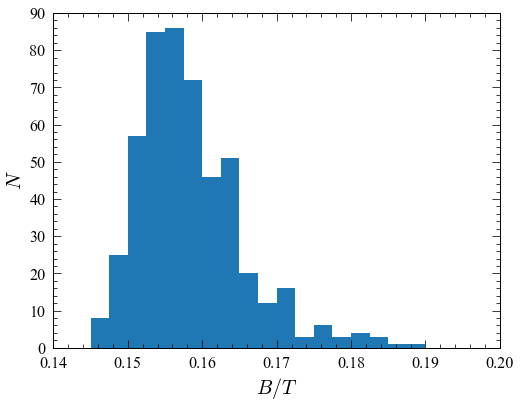

In [22]:
hist(b2t_values, bins=np.arange(0.14,0.2,0.0025));xlabel(r"$B/T$");ylabel(r"$N$")